#### Bivariate choropleth maps 
for the heatwave event and SoVI data. 

https://github.com/ahamilton144/WPB-bivariate-choropleth-maps/blob/main/WPB-bivariate-choropleth-map.ipynb <br>
https://waterprogramming.wordpress.com/2022/09/08/bivariate-choropleth-maps/

In [1]:
import glob
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.colors import rgb2hex
from generativepy.color import Color
from PIL import ImageColor
import geopandas as gpd
import contextily as cx
import numpy as np
import pandas as pd
import xarray as xr

/glade/work/mingge/miniconda3/envs/casper_2020/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
# SoVI data from Matt
flnm_shp = '/glade/work/mingge/SHAPEFILES/COUNTY_OREGON/sovi_3county_SD/sovi_3_county.shp'
shp_gpd = gpd.read_file(flnm_shp)

#### convert everything to latitude and longitude in geometry
####  "EPSG:4326" : CRS=WGS84 latitude-longitude projection
shp_gpd = shp_gpd.to_crs('EPSG:4326')

# Get lat-lon of geodataframe polygon, and then add them back. They will be used for interpolation
# I use centroid of the shape
# reproject geodataframe to a geographic CRS, e.g EPSG:4326 
# nc_counties = shp_gpd.to_crs(4326)
# shp_gpd = shp_gpd.set_crs('EPSG:4326')
shp_gpd['lon_centroid'] = shp_gpd.centroid.x  
shp_gpd['lat_centroid'] = shp_gpd.centroid.y

n_shp = len(shp_gpd.centroid)

#shp_gpd

/glade/scratch/mingge/ipykernel_169233/2758719027.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_gpd['lon_centroid'] = shp_gpd.centroid.x
/glade/scratch/mingge/ipykernel_169233/2758719027.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_gpd['lat_centroid'] = shp_gpd.centroid.y
/glade/scratch/mingge/ipykernel_169233/2758719027.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  n_shp = len(shp_gpd.centroid)


In [3]:
# to get complete list
# shp_gpd.columns.tolist()

#### Creating univariate choropleth maps using geopandas

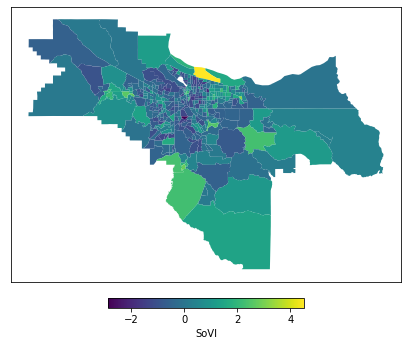

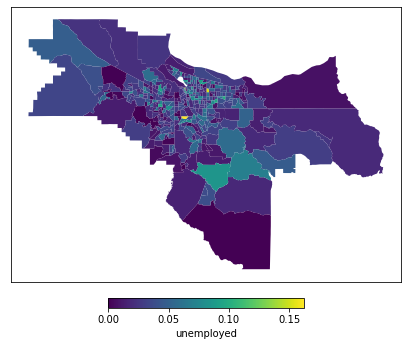

In [5]:
label_dict = {'sovi_devia': 'SoVI',
             'unemployed': 'unemployed'}

alpha = 1
dpi = 300

for attr, label in label_dict.items():
    fig, ax = plt.subplots(1,1, figsize=(7,10))
    shp_gpd.loc[shp_gpd[attr] >= -100].plot(attr, ax=ax, alpha=alpha, legend=True, 
             legend_kwds={'label':label, 'orientation':'horizontal', 'shrink': 0.5, 'pad': 0.03, 'alpha':alpha})
    #cx.add_basemap(ax = ax, crs=shp_gpd.crs) #, source=cx.providers.Stamen.TonerLite)
    _ = ax.set_xticks([])
    _ = ax.set_yticks([])
    #plt.savefig(f'figs/{attr}.jpg', dpi=dpi, bbox_inches='tight')

#### SoVI overlaided with frozen precipitation (hatched) of 2/11/2021

In [28]:
dir_prism = '/glade/campaign/mmm/c3we/prein/observations/PRISM/data/'
date_st  = '2021-02-11'
date_end = '2021-02-11'
date_s   = pd.date_range(date_st, date_end, freq='D').format(formatter=lambda x: x.strftime('%Y%m%d'))

ds = xr.open_dataset(dir_prism + 'Tmin/PRISM_daily_tmin_2021.nc')
tmin_3d = ds.sel(time=slice(date_st, date_end)).isel(rlat=slice(88,122), rlon=slice(26, 82)).Tmin

ds = xr.open_dataset(dir_prism + 'PR/PRISM_daily_ppt_2021.nc')
prec_3d = ds.sel(time=slice(date_st, date_end)).isel(rlat=slice(88,122), rlon=slice(26, 82)).PR
 
ice_2d = prec_3d.where(tmin_3d<0, drop=False).squeeze() 

In [29]:
# select value of centroid of each shapefile
ice_1d = np.zeros((n_shp))
for nn in range(n_shp):
    lat_0 = shp_gpd['lat_centroid'][nn]
    lon_0 = shp_gpd['lon_centroid'][nn]
    t = ice_2d.sel(rlon=lon_0, rlat=lat_0, method="nearest")
    ice_1d[nn]=t.values
    
shp_gpd['ice'] = ice_1d

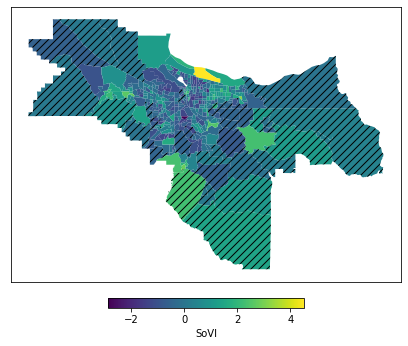

In [30]:
label_dict = {'sovi_devia': 'SoVI'}
              
alpha = 1
 
for attr, label in label_dict.items():
    fig, ax = plt.subplots(1,1, figsize=(7,10))
    shp_gpd.loc[shp_gpd[attr] >= -100].plot(attr, ax=ax, alpha=1, legend=True, 
             legend_kwds={'label':label, 'orientation':'horizontal', 'shrink': 0.5, 'pad': 0.03, 'alpha':alpha})
    shp_gpd.plot(ice_1d, ax=ax, hatch='///', alpha=0)
      
    _ = ax.set_xticks([])
    _ = ax.set_yticks([])

#### Creating a bivariate choropleth map

In [31]:
### percentile bounds defining upper boundaries of color classes
#percentile_bounds = [25, 50, 75, 100]

### function to convert hex color to rgb to Color object (generativepy package)
def hex_to_Color(hexcode):
    rgb = ImageColor.getcolor(hexcode, 'RGB')
    rgb = [v/256 for v in rgb]
    rgb = Color(*rgb)
    return rgb


### get corner colors from https://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/
c00 = hex_to_Color('#e8e8e8')
c01 = hex_to_Color('#be64ac')
c10 = hex_to_Color('#5ac8c8')
c11 = hex_to_Color('#3b4994')


'''
c00 = hex_to_Color('#e8e8e8')
c10 = hex_to_Color('#be64ac')
c01 = hex_to_Color('#5ac8c8')
c11 = hex_to_Color('#3b4994')


# additional sequential bivariate color schemes designed for use on light backgrounds.
# https://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/
c00 = hex_to_Color('#e8e8e8')
c10 = hex_to_Color('#c85a5a')
c01 = hex_to_Color('#64acbe')
c11 = hex_to_Color('#574249')

##
c00 = hex_to_Color('#e8e8e8')
c10 = hex_to_Color('#5ac8c8')
c01 = hex_to_Color('#be64ac')
c11 = hex_to_Color('#3b4994')

##
c00 = hex_to_Color('#e8e8e8')
c10 = hex_to_Color('#6c83b5')
c01 = hex_to_Color('#73ae80')
c11 = hex_to_Color('#2a5a5b')

##
c00 = hex_to_Color('#e8e8e8')
c10 = hex_to_Color('#c8b35a')
c01 = hex_to_Color('#9972af')
c11 = hex_to_Color('#804d36')
'''

### now create square grid of colors, using color interpolation from generativepy package
# num_grps = len(percentile_bounds_1)
num_grps = 3
c00_to_c10 = []
c01_to_c11 = []
colorlist = []

for i in range(num_grps):
    c00_to_c10.append(c00.lerp(c10, 1/(num_grps-1) * i))
    c01_to_c11.append(c01.lerp(c11, 1/(num_grps-1) * i))
for i in range(num_grps):
    for j in range(num_grps):
        colorlist.append(c00_to_c10[i].lerp(c01_to_c11[i], 1/(num_grps-1) * j))

### convert back to hex color
colorlist = [rgb2hex([c.r, c.g, c.b]) for c in colorlist]

In [32]:
### function to get bivariate color given two
def get_bivariate_choropleth_color(p1, p2, percentile_bounds_1, percentile_bounds_2):
    if p1>=-10 and p2>=0:
        count = 0
        stop = False
        for percentile_bound_p1 in percentile_bounds_1:
            for percentile_bound_p2 in percentile_bounds_2:
                if (not stop) and (p1 <= percentile_bound_p1):
                    if (not stop) and (p2 <= percentile_bound_p2):
                        color = colorlist[count]
                        stop = True
                count += 1
    else:
        color = [0.8,0.8,0.8,1]
    
    return color

In [33]:
aa=shp_gpd['sovi_devia'].values
print(aa.min(), aa.max())

-2.8556777978 4.50653213811


#### June 2021 heatwave (June 27 - June 30))

In [34]:
date_st  = '2021-06-27'
date_end = '2021-06-30'
date_s = pd.date_range(date_st, date_end, freq='D').format(formatter=lambda x: x.strftime('%Y%m%d'))

dir_prism = '/glade/campaign/mmm/c3we/prein/observations/PRISM/data/'
ds = xr.open_dataset(dir_prism + 'Tmax/PRISM_daily_tmax_2021.nc')
tmax_3d = ds.sel(time=slice(date_st, date_end)).isel(rlat=slice(88,122), rlon=slice(26, 82)) .Tmax

In [35]:
#maximum temperature (maximum over all days of the heatwave event).
tmax_2d = tmax_3d.max(dim='time')

In [36]:
arr_1d = np.zeros(( n_shp))
for nn in range(n_shp):
    lat_0 = shp_gpd['lat_centroid'][nn]
    lon_0 = shp_gpd['lon_centroid'][nn]
    t = tmax_2d.sel(rlon=lon_0, rlat=lat_0, method="nearest")
    arr_1d[nn]=t.values

In [20]:
print(arr_1d.min(), arr_1d.max())

37.55609893798828 46.038299560546875


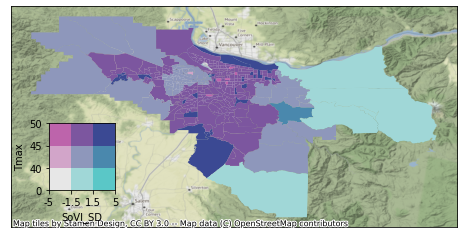

In [24]:
fig, ax = plt.subplots(1,1, figsize=(8,10))
attr = 'sovi'

percentile_bounds_x = [-1.5, 1.5, 5]
#percentile_bounds_x = [-5, 0, 12]
percentile_bounds_y = [40, 45, 50]

shp_gpd['color_bivariate'] = [get_bivariate_choropleth_color(p1, p2, percentile_bounds_x, percentile_bounds_y) for p1,p2 in zip(shp_gpd['sovi_devia'].values, arr_1d)]
shp_gpd.plot(ax=ax, color=shp_gpd['color_bivariate'], alpha=alpha, legend=False)

cx.add_basemap(ax = ax, crs=shp_gpd.crs) #, source=cx.providers.Stamen.TonerLite)
ax.set_xticks([])
ax.set_yticks([])

### now create inset legend
ax = ax.inset_axes([0.01,0.17,0.3,0.3])
ax.set_aspect('equal', adjustable='box')
count = 0
xticks = [-5]
yticks = [0]
for i,percentile_bound_p1 in enumerate(percentile_bounds_x):
    for j,percentile_bound_p2 in enumerate(percentile_bounds_y):
        percentileboxes = [Rectangle((i,j), 1, 1)]
        pc = PatchCollection(percentileboxes, facecolor=colorlist[count], alpha=alpha)
        count += 1
        ax.add_collection(pc)
        if i == 0:
            yticks.append(percentile_bound_p2)
    xticks.append(percentile_bound_p1)

_=ax.set_xlim([0,len(percentile_bounds_x)])
_=ax.set_ylim([0,len(percentile_bounds_y)])

_=ax.set_xticks(list(range(len(percentile_bounds_x)+1)), xticks)
_=ax.set_xlabel('SoVI_SD')
_=ax.set_yticks(list(range(len(percentile_bounds_y)+1)), yticks)
_=ax.set_ylabel('Tmax')

In [ ]:
https://stackoverflow.com/questions/8270981/how-to-highlight-specific-x-value-ranges
plt.axvspan(3, 6, color='red', alpha=0.5)
highlight specific x-value ranges